###### В данном Jupyter Notebook проводится подготовка валидационного сета

Пайплайн:

1. Скачивание данных HERG-central;
2. Стандартизация единиц измерения активности к herg каналам, удаление дубликатов;
3. Кластеризация соединений с помощью python-скрипта от PatWalter: https://github.com/PatWalters/kmeans Параметры: fp = morgan3, dim = 2048, sampels = 6000, clusters = 500;
4. Анализ разбиения выборки на кластеры;
5. Составление наиболее сбалансированного валидацинного датасета из соединений разных кластеров;
6. Сохранение подготовленных данных в .csv файлы.

# Обработка данных с HERG-central

In [154]:
import logging
import numpy as np
from numpy import mean, std, zeros
from pandas import DataFrame
import pandas as pd
from pathlib import Path
import sys
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, MolStandardize, DataStructs, ChemicalFeatures
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.datasets import make_classification 
from tqdm import tqdm
import xgboost
from xgboost import XGBRFClassifier
#import time

In [155]:
#! pip install tqdm

Загрузим датасет

In [72]:
df = pd.read_csv('herg_central.txt', delimiter = "\t")

In [73]:
df.isna().sum()

SMILES                         0
PubChem Substance ID           0
hERG inhibition (%) at 1uM     0
hERG inhibition (%) at 10uM    0
dtype: int64

In [74]:
df = df.drop_duplicates(subset ="PubChem Substance ID")
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM
0,C1=CC2=NC3=C(C=C(C(=NC(=O)C4=CC=CO4)N3CC5=CC=C...,22403712,-10.1124,-32.88202
1,C1C(CN(C1C(=O)OCC(=O)C2=CC=CC=C2Cl)S(=O)(=O)C3...,22411435,5.5191,4.12648
2,C1COCCN1C(=O)OC2=CC3=C(C=C2)C(=O)/C(=C/C4=CC=C...,17513249,9.5532,5.23978
3,CC1=NC2=CC=CC=C2C(=C1)C(=O)N/N=C/C3=CC(=CC=C3)...,17512209,-0.2112,-5.44332
4,COCCNC(=O)C1=C(N(C2=NC3=CC=CC=C3N=C12)CC4=CC=C...,14729741,12.6230,14.73378
...,...,...,...,...
306890,C1CCN(C1)S(=O)(=O)C2=CC=C(C=C2)C(=O)OCC(=O)NC3...,57262925,4.8576,1.38128
306891,C1CN(CCN1CC(=O)NC2=CC=C(C=C2)C(=O)N)S(=O)(=O)C...,57264745,4.4922,-3.78132
306892,CC1=CC(=C(C(=C1C)S(=O)(=O)N2CCN(CC2)C(=O)CNC(=...,57259638,-0.9701,-13.56112
306893,C1COCCN1C2=C(C=C(C=C2)C(F)(F)F)NC(=O)COC(=O)C3...,57261004,-7.1374,-25.02142


Удалим соли

In [156]:
df = df.drop(df[df.SMILES.str.contains(r'[.]')].index)
len(df)

294939

In [157]:
k = 0
l = 0
index_nan = []
for i in df["SMILES"]:
    k += 1
    if i == "":
        index_nan.append(df_all.index[k-1])
        l += 1
print(f"Number of str-nan:{l}")
print(f"Index of nan:{index_nan}")

Number of str-nan:0
Index of nan:[]


Проставим класс активности на основе значения % ингибирования при концентрации 10 мкМ

In [77]:
def count_class(df):
    activity_class =[]
    count = 0
    for index, row in df.iterrows():
        value = float(row["hERG inhibition (%) at 10uM"])
        if value > 50:
             activity_class.append(1)
        elif value == 50:
             activity_class.append(1)
        else:
            activity_class.append(0)
    df['class'] = activity_class
    return df

In [78]:
df = count_class(df)

In [79]:
df["class"].sum()

225

Всего лишь 225 акивных соединений. На 300 тысяч это очень мало, выборка несбалансированная. 

In [81]:
df = df.sort_values('PubChem Substance ID')
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
128094,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
188700,CN1C(=O)CC(SC1=NC2=CC(=CC=C2)OC)C(=O)NC3=CC=CC...,842136,7.2549,-2.51872,0
260906,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
167070,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
18129,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
...,...,...,...,...,...
294502,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
58591,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
176649,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
58585,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


In [82]:
df.reset_index(drop=True, inplace=True)
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
1,CN1C(=O)CC(SC1=NC2=CC(=CC=C2)OC)C(=O)NC3=CC=CC...,842136,7.2549,-2.51872,0
2,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
3,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
4,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
...,...,...,...,...,...
294934,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
294935,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
294936,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
294937,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


Сохраним промежуточный результат.

In [83]:
df.to_csv("herg_central_class.csv", encoding='utf-8', index=False)

In [84]:
df = pd.read_table('herg_central_class.csv', sep = ",", engine='python')
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
1,CN1C(=O)CC(SC1=NC2=CC(=CC=C2)OC)C(=O)NC3=CC=CC...,842136,7.2549,-2.51872,0
2,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
3,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
4,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
...,...,...,...,...,...
294934,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
294935,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
294936,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
294937,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


In [85]:
def standardize_smiles(df):
    logs = 0
    mols = []
    for i in tqdm(df["SMILES"]):    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Errors: {logs}")
    df["ROMol"] = mols
    return df

In [86]:
df_mol = standardize_smiles(df)

100%|████████████████████████████████████████████████████████████████████████| 294939/294939 [01:16<00:00, 3845.14it/s]

Errors: 0


In [87]:
df_mol["class"].sum()

225

In [88]:
df_mol.isna().sum()

SMILES                         0
PubChem Substance ID           0
hERG inhibition (%) at 1uM     0
hERG inhibition (%) at 10uM    0
class                          0
ROMol                          0
dtype: int64

In [18]:
def calc_morgan(mols):
    """ генерация молекулярных отпечатков по методу Моргана с радиусом 3
    """
    #t0 = time.time()
    for_df = []
    i=0
    for m in tqdm(mols):
        i+=1
        #t1 = time.time()
        #print("Processing compound {} ({}%)".format(i, 100*i//len(mols)), end="")
        arr = zeros((1,), dtype=int)
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(m, 3, 4096), arr)
        for_df.append(arr)
        #t2 = time.time()
        #print(" {}s (total: {}s)".format(t2-t1, t2-t0))
    return DataFrame(for_df)

In [19]:
df = calc_morgan(df["ROMol"])

100%|████████████████████████████████████████████████████████████████████████| 294939/294939 [01:18<00:00, 3753.61it/s]


MemoryError: 

Воспольуемся реализацией кластеризации по методку KNN  от  PatWalters https://github.com/PatWalters/kmeans
Параметры: fp = morgan3, dim = 2048, sampels = 6000, clusters = 500. 

In [61]:
df1 = df[["SMILES", "class"]]
df1.to_csv("herg_central_class.smi", sep = " ", encoding='utf-8', index=False)

Теперь посмотрим, что получилось после кластеризации:

In [63]:
df_clust = pd.read_csv("herg_central_clusters.csv")

In [65]:
PandasTools.AddMoleculeColumnToFrame(df_clust,'SMILES','Mol')

In [90]:
len(df_clust)

294939

In [133]:
df_clust = df_clust.sort_values("Name")
df_clust.reset_index(drop=True, inplace=True)


In [95]:
df_clust = pd.concat([df_clust,df[["PubChem Substance ID", "hERG inhibition (%) at 10uM", "class"]]],axis=1)

,SMILES,Name,Cluster,Center,Mol,PubChem Substance ID,hERG inhibition (%) at 10uM,class
422,COc1ccc(N2CCN(C(=O)CSc3nnc4nc(C)cc(C)n34)CC2)cc1,842669,220,Yes,,842669,-26.13582,0
792,CC(C)(C)NC(=O)C(c1ccco1)N(C(=O)c1csnn1)c1ccccc1,843156,277,Yes,,843156,-4.55092,0
1016,Cc1ccc(CN(Cc2cccnc2)C(=O)CN2C(=O)COc3ccccc32)o1,843464,275,Yes,,843464,-1.87702,0
4167,Cc1ccc(S(=O)(=O)Cn2nnnc2CN2CCN(C(=O)c3ccco3)CC...,847703,99,Yes,,847703,-15.77052,0
6199,O=C(CC(=O)NCc1cccnc1)NCc1cccnc1,850495,203,Yes,,850495,-5.35182,0
6457,O=C(CSCC(=O)NCc1ccco1)NCc1ccco1,850855,297,Yes,,850855,-66.00582,0
7655,O=C(NCC1CCCO1)c1ccc(C(=O)NCC2CCCO2)cc1,852468,111,Yes,,852468,0.97428,0
7880,O=C(N1CCOCC1)N1CCOCC1,852788,76,Yes,,852788,-21.66022,0
8667,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1,855767,217,Yes,,855767,9.42208,0
8845,CCOc1c(C#N)c(C#N)c2nc(C)cc(C)n12,856132,478,Yes,,856132,-13.09192,0

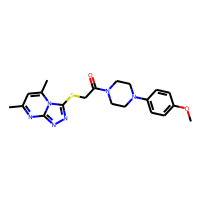
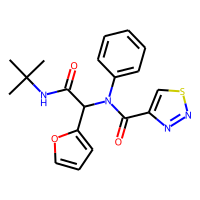
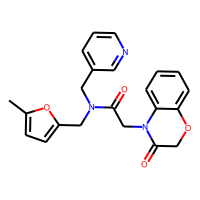
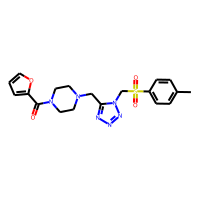
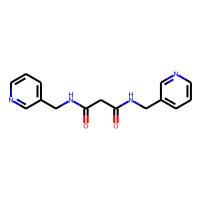
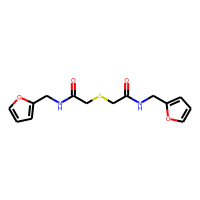
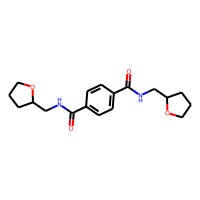
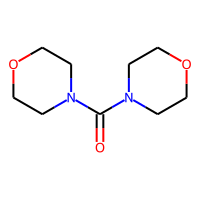
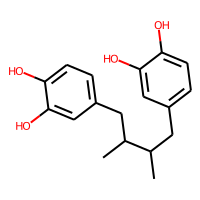
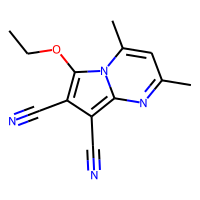
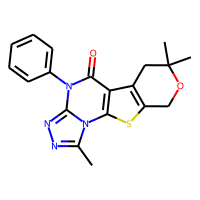
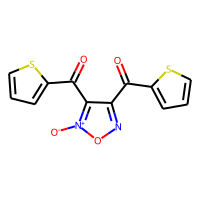
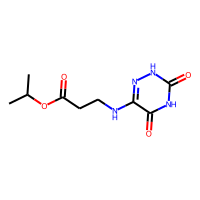
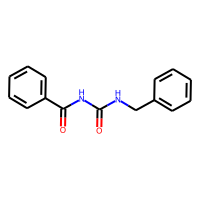
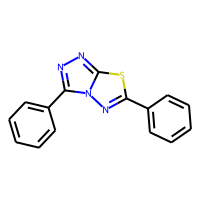

In [149]:
df_clust.loc[df_clust['Center'] == 'Yes'].head(15)

Проверим, что нумерация с df_mol точно совпадает и мы правильно проставили класс активности:

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class,ROMol
422,CC1=CC(=NC2=NN=C(N12)SCC(=O)N3CCN(CC3)C4=CC=C(...,842669,-2.977,-26.13582,0,

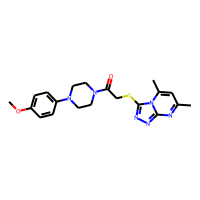

In [161]:
df_mol.loc[df_mol['PubChem Substance ID'] == 842669]

Проверим что у нас около 500 центров кластеризации:

In [147]:
df_clust["Center"].value_counts()

No     294442
Yes       497
Name: Center, dtype: int64

Построим гистограмму рапределения соединений по кластерам:

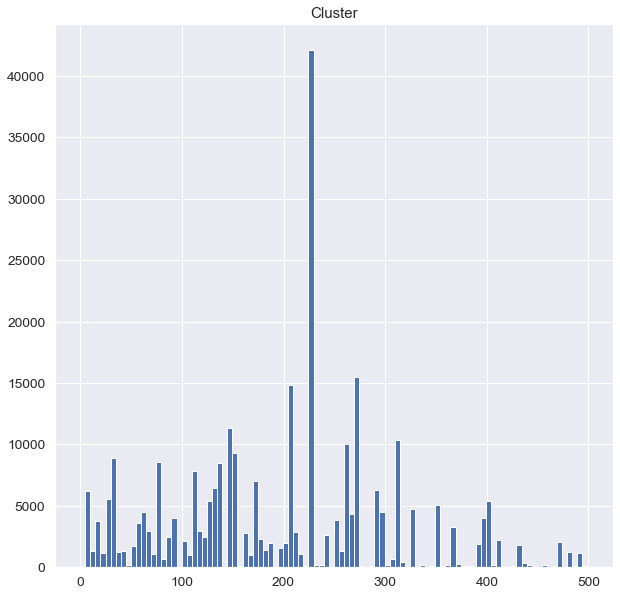

In [110]:
ax = df_clust.hist("Cluster",bins=100,figsize=(10,10))

In [122]:
#p = ax.patches
#p[230].get_xy()

In [124]:
df_clust['Cluster'].value_counts()

226    38879
273    15432
205    12509
314    10253
262     9935
       ...  
128        1
463        1
103        1
175        1
52         1
Name: Cluster, Length: 497, dtype: int64

Самый большой кластер под номером 226, взглянем на его соединения:

,SMILES,Name,Cluster,Center,Mol,PubChem Substance ID,hERG inhibition (%) at 10uM,class
3,CC1(C)NC(=O)N(CC(O)COC2CCCCC2)C1=O,842138,226,No,,842138,8.64368,0
4,[O-][n+]1ccc(C2CC2)cc1,842139,226,No,,842139,7.12878,0
9,CC(C)Nc1nc(C#N)nc(NC(C)C)n1,842145,226,No,,842145,0.21918,0
19,CN1C=CC2=C(C#N)C(N)C(C#N)(C#N)C(c3ccccc3)C2C1,842157,226,No,,842157,9.48638,0
24,CC(=O)OCN(C#N)c1nc(N(C)C)nc(N(C)C)n1,842165,226,No,,842165,5.79858,0
34,CC12COC3(C(=O)Nc4cccnc4)CC1CCC32C,842178,226,No,,842178,-9.46142,0
36,Cc1ccccc1-c1nc2cc(N)ccc2o1,842180,226,No,,842180,-15.55492,0
39,CCOC(=O)C1=C(N)OC2=C(C(=O)CC(C)(C)C2)C1c1ccoc1,842183,226,No,,842183,-16.10072,0
64,CCc1oc(C(=O)O)cc1COC,842213,226,No,,842213,-9.57252,0
71,O=C1c2ccccc2C(=O)N1Cc1nc2ccccc2o1,842221,226,No,,842221,22.46148,0

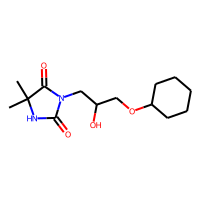
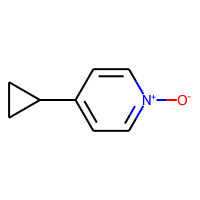
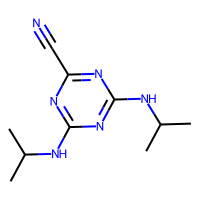
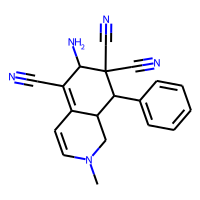
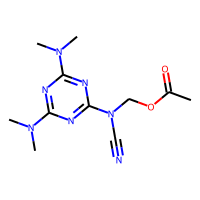
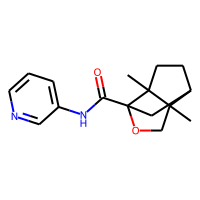
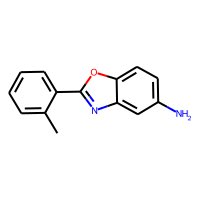
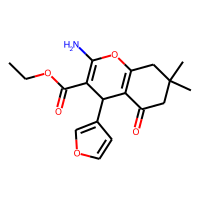
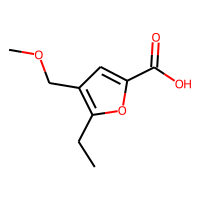
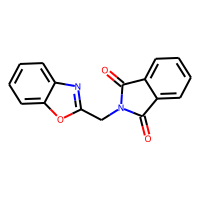
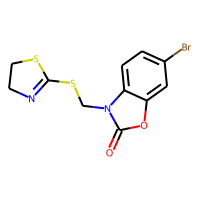
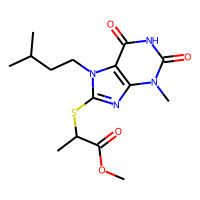
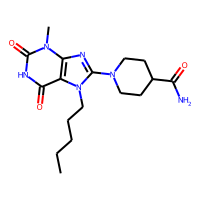
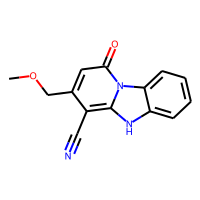
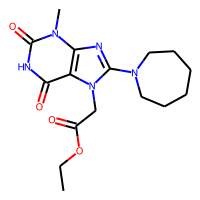

In [128]:
df_clust.loc[df_clust['Cluster'] == 226].head(15)

Довольно разнородная выборка...

In [131]:
valid_set = pd.DataFrame(df_clust.drop_duplicates("Cluster"))
len(valid_set)

497

In [132]:
valid_set["class"].sum()

1

Таким образом, мы получили для валидации датасет, совершенно не содержащий активных молекул. Это плохой способ проверить модель.

Попробуем это исправить

In [102]:
unique_targets = df_clust['class'].unique()
target_dict = dict([(x,y) for x,y in zip(unique_targets,range(0,len(unique_targets)))])
num_targets = len(unique_targets)
target_dict

{0: 0, 1: 1}

In [107]:
mat = []
for k,v in df_clust.groupby("Cluster"):
    row_vec = np.zeros(num_targets,dtype=np.int8)
    for tgt,count in v['class'].value_counts().iteritems():
        tgt_idx = target_dict[tgt]
        row_vec[tgt_idx] = count
    mat.append(row_vec)
mat = np.array(mat)
out_df = pd.DataFrame(mat.transpose())
out_df.insert(0,"Class",unique_targets)
out_df

,Class,0,1,2,3,4,5,6,7,8,...,487,488,489,490,491,492,493,494,495,496
0,0,11,5,27,17,83,-40,99,31,-11,...,-4,57,21,17,19,20,9,10,23,4
1,1,0,0,0,0,0,3,3,0,1,...,1,0,0,0,0,0,0,0,0,0


In [108]:
(out_df != 0).sum(axis=1)

0    497
1     72
dtype: int64

Таким образом, неактивные соединения присутствуют во всех кластерах. В то время, как активные лишь в 72 кластерах.
Разделим активные и неактивные соединения, а далее отберем по одному объекту из кажого кластера. 

In [136]:
def get_uniq_from_clust(df, activity):
    df = df[(df['class']==activity)]
    val_df = pd.DataFrame(df.drop_duplicates("Cluster"))
    return val_df

In [139]:
df_clust_active = get_uniq_from_clust(df = df_clust, activity = 1)
len(df_clust_active)

71

In [140]:
df_clust_inactive = get_uniq_from_clust(df = df_clust, activity = 0)
len(df_clust_inactive)

497

In [141]:
val_set = pd.concat([df_clust_active, df_clust_inactive])

In [142]:
len(val_set)

568

In [144]:
del val_set['Mol']

In [145]:
val_set.to_csv("herg_valid_set.csv", encoding='utf-8', index=False)

Вывод:
    В резултате мы получили валидационный сет для проверки модели, содержащий 71/568 (12,5%) активных соединений и 497/568 (87,5%) неактивных соединений. 